## Code to analyze FS output

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
    

In [2]:
qpn_dir = "/home/nikhil/projects/Parkinsons/QPN_processing/"

ukbb_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

FS_dir = f"{qpn_dir}/derivatives/freesurfer-6.0.1-agg/"

qpn_DKT_csv = f"{FS_dir}/DKTatlas_average_thickness.csv"

tabular_dir = f"{qpn_dir}/tabular/"

current_release = "release_Nov2022"

# Current mr_proc manifest
current_mr_proc_manifest_csv = f"{tabular_dir}{current_release}/mr_proc_manifest.csv"


# DKT fields and labels
ukbb_dkt_fields = f"{ukbb_dir}/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{ukbb_dir}/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{ukbb_dir}/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{ukbb_dir}/region_field_ids/UKBB_ASEG_vol_Fields.csv"

In [67]:
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]
DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)
DKT_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_roi
0,62,27174,Mean_thickness of caudalanteriorcingulate (lef...,Mean_thickness,caudalanteriorcingulate,lh,lh_caudalanteriorcingulate
1,63,27267,Mean_thickness of caudalanteriorcingulate (rig...,Mean_thickness,caudalanteriorcingulate,rh,rh_caudalanteriorcingulate
2,64,27175,Mean_thickness of caudalmiddlefrontal (left he...,Mean_thickness,caudalmiddlefrontal,lh,lh_caudalmiddlefrontal
3,65,27268,Mean_thickness of caudalmiddlefrontal (right h...,Mean_thickness,caudalmiddlefrontal,rh,rh_caudalmiddlefrontal
4,66,27176,Mean_thickness of cuneus (left hemisphere),Mean_thickness,cuneus,lh,lh_cuneus


In [29]:
CT_DKT_df = pd.read_csv(qpn_DKT_csv)
CT_DKT_df = CT_DKT_df.drop(columns=["Unnamed: 0"])
CT_DKT_df = CT_DKT_df.rename(columns={"subject_id":"bids_id"})

qpn_bids_ids = list(CT_DKT_df["bids_id"])
print(f"n_bids: {len(qpn_bids_ids)}")
CT_DKT_df.head()

n_bids: 163


,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27288,27289,27290,27291,27292,27293,27294,27295,27296,27297
0,sub-PD00668D788170,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.350,2.049,...,2.445,2.416,2.357,2.135,2.402,2.285,2.604,2.372,2.272,2.835
1,sub-MNI0056D864854,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.148,2.106,...,2.246,2.401,2.372,2.167,2.415,2.434,2.644,2.386,2.092,2.617
2,sub-PD01677D994657,2.741,2.577,1.888,2.819,2.552,2.468,2.683,2.173,2.225,...,2.539,2.436,2.794,2.336,2.575,2.247,2.895,2.770,2.654,3.138
3,sub-MNI0147D193242,2.736,2.149,2.011,3.295,2.705,2.265,2.955,2.229,2.230,...,2.358,2.213,2.769,2.129,2.357,1.929,2.594,2.236,2.129,2.675
4,sub-PD00032D891772,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.257,2.125,...,2.533,2.319,2.816,2.294,2.487,2.203,2.784,2.480,2.380,2.736


In [30]:
qpn_demographics_df = pd.read_csv(current_mr_proc_manifest_csv)

qpn_demographics_df = qpn_demographics_df[qpn_demographics_df["bids_id"].isin(qpn_bids_ids)]

print(f"n_demographics_subs: {len(qpn_demographics_df)}")
qpn_demographics_df.head()

n_demographics_subs: 161


,participant_id,sex,dob,group,visit_01,visit_02,bids_id
0,MNI0056,M,1942-05-21,PD,2021-08-18,NaN,sub-MNI0056D864854
1,MNI0058,M,1964-03-14,PD,2021-08-18,NaN,sub-MNI0058D197308
2,MNI0068,M,1952-08-05,PD,2021-08-27,NaN,sub-MNI0068D842090
3,MNI0079,F,1971-11-25,PD,2021-12-22,NaN,sub-MNI0079D760662
4,MNI0103,M,1939-08-17,PD,2021-08-11,NaN,sub-MNI0103D369057


In [31]:
qpn_demographics_df.groupby(["group","sex"]).count()

participant_id  dob  visit_01  visit_02  bids_id
group sex                                                  
CTRL  F                21   20        21         0       21
      M                10   10        10         1       10
PD    F                45   45        45         3       45
      M                84   84        84         9       84

In [32]:
demo_cols = ["bids_id","sex","dob","group"]
CT_DKT_df = pd.merge(CT_DKT_df,qpn_demographics_df[demo_cols],on="bids_id",how="left")

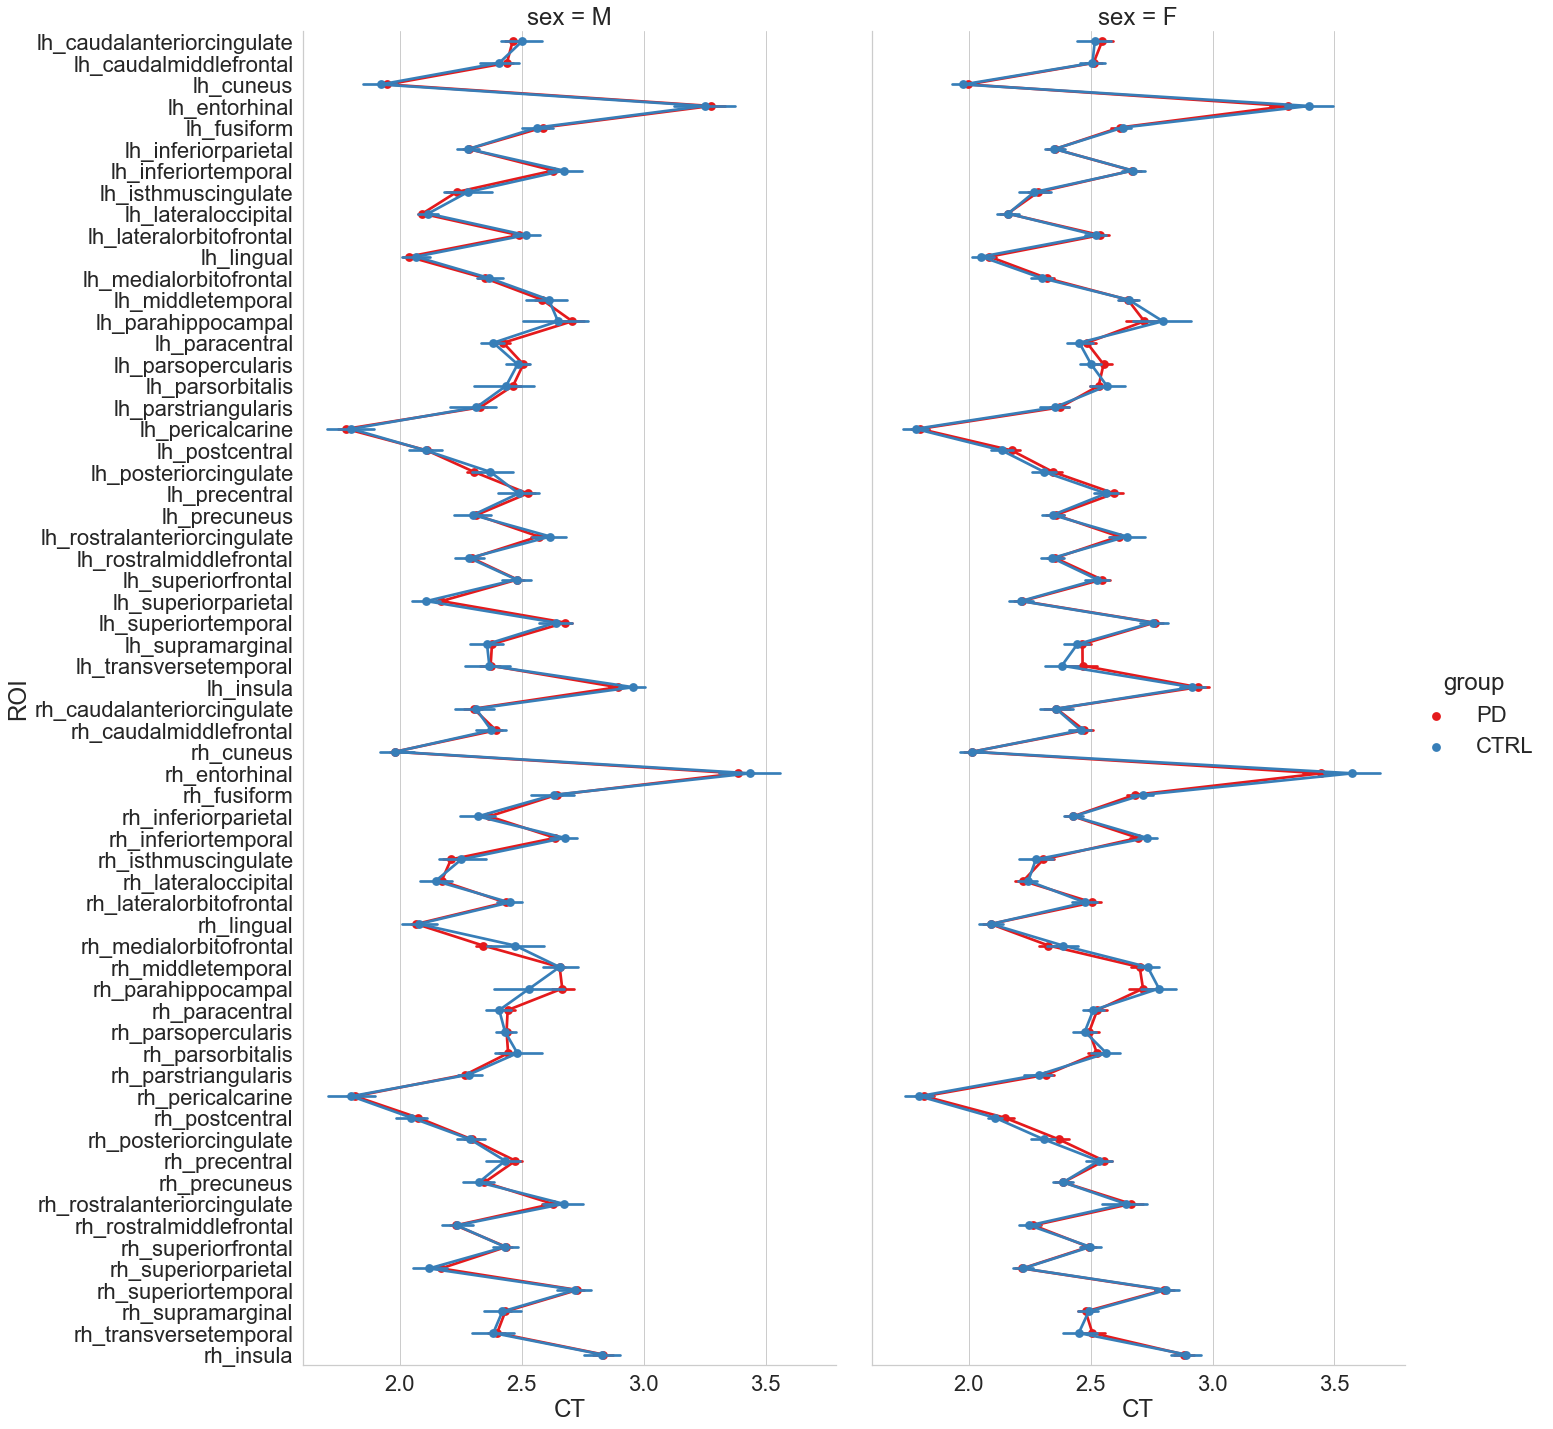

In [74]:
CT_DKT_df = CT_DKT_df.rename(columns=DKT_field_roi_dict)
CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols,
    var_name="ROI", 
    value_name="CT",
)

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

palette = 'Set1'
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):

    g = sns.catplot(y="ROI",x="CT", hue="group", col="sex",kind="point",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)